In [1]:
from collections import defaultdict
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Input, Model, load_model, model_from_json
from librosa import cqt
import numpy as np
import os
import pickle
import shutil
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import sys
from warnings import warn
from zipfile import ZipFile

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from music_transcription.pitch_detection.cnn_cqt_pitch_detection import CnnCqtFeatureExtractor
from music_transcription.pitch_detection.read_data import get_wav_and_truth_files, read_data_y

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5005)


ImportError: cannot import name 'get_wav_and_truth_files'

In [2]:
DATASETS_CV = {1, 2}
DATASETS_ADDITIONAL = {3, 9, 10, 11}

sample_rate = 44100
subsampling_step = 1
min_pitch = 40
max_pitch = 88
onset_group_threshold_seconds = 0.05

image_data_format = 'channels_first'
cqt_configs = [
    {
        'hop_length': 512,
        'fmin': 55.0,
        'n_bins': 180,
        'bins_per_octave': 36,
        'scale': False,
    },
]
n_frames_before = 15
n_frames_after = 20

LOSS = 'binary_crossentropy'
OPTIMIZER = 'adam'
METRICS = None
BATCH_SIZE = 256

In [3]:
wav_file_paths_cv, truth_dataset_format_tuples_cv = get_wav_and_truth_files(DATASETS_CV)
wav_file_paths_additional, truth_dataset_format_tuples_additional = get_wav_and_truth_files(DATASETS_ADDITIONAL)

C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping AR_Lick11_FN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping AR_Lick11_KN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping AR_Lick11_MN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:135: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\audio\desktop.ini, not a .wav file.
  warn('Skipping ' + path_to_wav + ', not a .wav file.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping FS_Lick11_FN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users

In [4]:
folds = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for k, (train_indices, test_indices) in enumerate(k_fold.split(wav_file_paths_cv)):
    # if k > 0:
    #     print('Skipping split {}'.format(k))
    #     continue
    
    wav_file_paths_train = [wav_file_paths_cv[i] for i in train_indices] + wav_file_paths_additional
    truth_dataset_format_tuples_train = [truth_dataset_format_tuples_cv[i] for i in train_indices] + truth_dataset_format_tuples_additional
    wav_file_paths_test = [wav_file_paths_cv[i] for i in test_indices]
    truth_dataset_format_tuples_test = [truth_dataset_format_tuples_cv[i] for i in test_indices]
    
    data_train, y_train, wav_file_paths_train_valid, truth_dataset_format_tuples_train_valid = read_data_y(
        wav_file_paths_train, truth_dataset_format_tuples_train,
        sample_rate, subsampling_step,
        min_pitch, max_pitch,
        onset_group_threshold_seconds=onset_group_threshold_seconds
    )
    
    feature_extractor = CnnCqtFeatureExtractor(image_data_format, sample_rate, cqt_configs, n_frames_before, n_frames_after)
    list_of_X_train, sample_file_indexes_train = feature_extractor.fit_transform(data_train)

    data_test, y_test, wav_file_paths_test_valid, truth_dataset_format_tuples_test_valid = read_data_y(
        wav_file_paths_test, truth_dataset_format_tuples_test,
        sample_rate, subsampling_step,
        min_pitch, max_pitch,
        onset_group_threshold_seconds=onset_group_threshold_seconds
    )
    list_of_X_test, sample_file_indexes_test = feature_extractor.transform(data_test, verbose=True)

    folds.append((list_of_X_train, y_train, list_of_X_test, y_test))

C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\AR_NH_IV.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))
C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\AR_NH_IX.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))
C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\FS_NH_IV.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))
C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\FS_NH_IX.xml, pitch 92 is out of range.
  warn('Skipping

Creating spectrograms
Fitting standard scalers for each spectrogram and bin
(547471, 180)
3.68417139688
22.4409437959
Standardizing for each spectrogram and bin
-3.88643841832e-17
1.0
(4761, 36, 180)
Reshaping data
(4761, 1, 36, 180)
Creating spectrograms


C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\LP_NH_IX.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))


(41682, 180)
5.5261683425
27.6109156022
Standardizing for each spectrogram and bin
0.0992231932843
1.17145313113
(338, 36, 180)
Reshaping data
(338, 1, 36, 180)
Creating spectrograms
Fitting standard scalers for each spectrogram and bin
(557431, 180)
3.77812439059
22.559128891
Standardizing for each spectrogram and bin
2.89740737771e-16
1.0
(4803, 36, 180)
Reshaping data
(4803, 1, 36, 180)
Creating spectrograms
(31722, 180)
4.45353667809
27.4566022803
Standardizing for each spectrogram and bin
0.0455604395835
1.17690111469
(296, 36, 180)
Reshaping data
(296, 1, 36, 180)
Creating spectrograms
Fitting standard scalers for each spectrogram and bin
(559395, 180)
3.75710636671
22.61410081
Standardizing for each spectrogram and bin
4.20576863807e-17
1.0
(4767, 36, 180)
Reshaping data
(4767, 1, 36, 180)
Creating spectrograms
(29758, 180)
4.89321297359
26.880949377
Standardizing for each spectrogram and bin
0.0621791682988
1.0733988344
(332, 36, 180)
Reshaping data
(332, 1, 36, 180)
Creating s

In [ ]:
counts = defaultdict(int)
for ds in [t[1] for t in truth_dataset_format_tuples_cv]:
    counts[ds] += 1
print(counts)

for k, (train_indices, test_indices) in enumerate(k_fold.split(wav_file_paths_cv)):
    print(k)
    counts_test_k = defaultdict(int)
    for ds in [t[1] for t in [truth_dataset_format_tuples_cv[i] for i in test_indices]]:
        counts_test_k[ds] += 1
    print(counts_test_k)

In [5]:
def predict(model, proba_threshold, list_of_X, y, epsilon=1e-7):
    proba_matrix = model.predict(list_of_X)
    y = proba_matrix > proba_threshold
    y = y.astype(np.int8)

    # Make sure at least one pitch is returned.
    for probas, labels in zip(proba_matrix, y):
        if labels.sum() == 0:
            max_proba = max(probas)
            max_index = np.where(np.logical_and(probas > max_proba - epsilon, probas < max_proba + epsilon))[0][0]
            labels[max_index] = 1

    return y

def print_metrics(y, y_predicted):
    print('Accuracy: {}'.format(round(accuracy_score(y, y_predicted), 4)))
    print(classification_report(y, y_predicted, digits=3,
                                target_names=[str(pitch) for pitch in range(min_pitch, max_pitch + 1)]))

In [6]:
def create_model_1(list_of_X, n_output_units):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(20, (7, 3), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 3))(conv)
        conv = Conv2D(20, (3, 3), padding='valid')(conv)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 3))(conv)
        conv = Dropout(0.25)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(0.5)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_2(list_of_X, n_output_units, dropout_conv=0.25, dropout_dense=0.5):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(10, (7, 3), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 3))(conv)
        conv = Conv2D(20, (3, 3), padding='valid')(conv)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 3))(conv)
        conv = Dropout(dropout_conv)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(dropout_dense)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_3(list_of_X, n_output_units):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(49, (16, 6), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 29))(conv)
        conv = Dropout(0.25)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(32)(z)
    z = Activation('relu')(z)
    z = Dropout(0.5)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_4(list_of_X, n_output_units, dropout_conv=0.25, dropout_dense=0.5):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(10, (7, 3), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 3))(conv)
        conv = Dropout(dropout_conv)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(dropout_dense)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    # model.summary()

    return model

def create_model_5(list_of_X, n_output_units,
                   dropout_conv, dropout_dense,
                   n_filters, filter_size, pool_size):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(n_filters, filter_size, padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=pool_size)(conv)
        conv = Dropout(dropout_conv)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(dropout_dense)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_6(list_of_X, n_output_units):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(10, (15, 6), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 3))(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(256)(z)
    z = Activation('relu')(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_7(list_of_X, n_output_units, dropout_conv=0.1, dropout_dense=0.2):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(10, (15, 6), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = Conv2D(20, (5, 2), padding='valid')(conv)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(1, 3))(conv)
        conv = Dropout(dropout_conv)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(dropout_dense)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    # model.summary()

    return model

def create_model_8(list_of_X, n_output_units,
                   dropout_conv, dropout_dense,
                   n_filters, filter_size, pool_size=None):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(n_filters, filter_size, strides=(5, 1), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = Dropout(dropout_conv)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(128)(z)
    z = Activation('relu')(z)
    z = Dropout(dropout_dense)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_9(list_of_X, n_output_units,
                   dropout_conv, dropout_dense,
                   n_filters, filter_size, pool_size):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(n_filters, filter_size, padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=pool_size)(conv)
        conv = Dropout(dropout_conv)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(64)(z)
    z = Activation('relu')(z)
    z = Dropout(dropout_dense)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_10(list_of_X, n_output_units,
                    dropout_conv=None, dropout_dense=None,
                    n_filters=None, filter_size=None, pool_size=None):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(10, (10, 3), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(6, 3))(conv)
        conv = Dropout(0.15)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

def create_model_11(list_of_X, n_output_units,
                    dropout_conv=None, dropout_dense=None,
                    n_filters=None, filter_size=None, pool_size=None):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(10, (10, 3), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(6, 3))(conv)
        conv = Dropout(0.15)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

        conv = Conv2D(512, (10, 180), strides=(5, 1), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(2, 1))(conv)
        conv = Dropout(0.25)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks)
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

In [7]:
def train_and_evaluate(folds, create_model,
                       dropout_conv=None, dropout_dense=None, proba_threshold=0.5,
                       n_filters=None, filter_size=None, pool_size=None,
                       verbose=False):
    y_test_all_folds = None
    y_test_predicted_all_folds = None
    for i, (list_of_X_train, y_train, list_of_X_test, y_test) in enumerate(folds):
        if verbose:
            fit_verbose = 2
            validation_data = (list_of_X_test, y_test)
        else:
            fit_verbose = 0
            validation_data = None
        
        # model_dir = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        # os.mkdir(model_dir)

        model = create_model(
            list_of_X_train, max_pitch - min_pitch + 1,
            dropout_conv, dropout_dense,
            n_filters, filter_size, pool_size
        )
        model.fit(list_of_X_train, y_train,
                  epochs=1000,
                  batch_size=BATCH_SIZE,
                  sample_weight=None,
                  class_weight=None,
                  callbacks=[EarlyStopping(monitor='loss', patience=6),
                             # ModelCheckpoint(os.path.join(model_dir, 'model.' + str(i) + '.{epoch:02d}-{val_loss:.4f}.hdf5'),
                             #                 monitor='val_loss', save_best_only=True)
                            ],
                  verbose=fit_verbose,
                  validation_data=validation_data,
                 )

        # Load model with lowest val_loss
        # path_to_model = max([os.path.join(model_dir, file)
        #                      for file in os.listdir(model_dir)
        #                      if file.startswith('model.' + str(i) + '.')])
        # print(path_to_model)
        # model = load_model(path_to_model)

        y_test_predicted = predict(model, proba_threshold, list_of_X_test, y_test)
        if verbose:
            print_metrics(y_test, y_test_predicted)

        if y_test_all_folds is None:
            y_test_all_folds = y_test
        else:
            y_test_all_folds = np.concatenate((y_test_all_folds, y_test))

        if y_test_predicted_all_folds is None:
            y_test_predicted_all_folds = y_test_predicted
        else:
            y_test_predicted_all_folds = np.concatenate((y_test_predicted_all_folds, y_test_predicted))

    print_metrics(y_test_all_folds, y_test_predicted_all_folds)

# print('dropout_conv={}, dropout_dense={}, proba_threshold={}, n_filters={}, filter_size={}, pool_size={}'.format(
#     dropout_conv, dropout_dense, proba_threshold, n_filters, filter_size, pool_size
# ))

print('model_11')
train_and_evaluate(folds, create_model_11, proba_threshold=0.3, verbose=True)

# print('model_8')
# train_and_evaluate(folds, create_model_8,
#                    dropout_conv=0.25, dropout_dense=0.2, proba_threshold=0.5,
#                    n_filters=512, filter_size=(36, 180),
#                    verbose=True)

model_11
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 36, 180)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 27, 178)   310                                          
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 6, 1)     922112                                       
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10, 27, 178)   0                                            
__________________________________________________________________________________

D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 36, 180)    0                                            
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 10, 27, 178)   310                                          
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 512, 6, 1)     922112                                       
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 10, 27, 178)   0                                            
___________________________________________________________________________________________

D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 36, 180)    0                                            
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 10, 27, 178)   310                                          
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 512, 6, 1)     922112                                       
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 10, 27, 178)   0                                            
___________________________________________________________________________________________

In [72]:
list_of_X_train, y_train, list_of_X_test, y_test = folds[0]
fit_verbose = 2
validation_data = (list_of_X_test, y_test)

# model = create_model_8(list_of_X_train, max_pitch - min_pitch + 1,
#                        0.25, 0.2, 1024, (10, 180))
# model = create_model_10(list_of_X_train, max_pitch - min_pitch + 1)
model = create_model_11(list_of_X_train, max_pitch - min_pitch + 1)
model.fit(list_of_X_train, y_train,
          epochs=1000,
          batch_size=BATCH_SIZE,
          sample_weight=None,
          class_weight=None,
          callbacks=[EarlyStopping(monitor='loss', patience=6),
                     # ModelCheckpoint(os.path.join(model_dir, 'model.' + str(i) + '.{epoch:02d}-{val_loss:.4f}.hdf5'),
                     #                 monitor='val_loss', save_best_only=True)
                    ],
          verbose=fit_verbose,
          validation_data=validation_data,
         )

for proba_threshold in [0.3]:# [0.2, 0.3, 0.4, 0.5, 0.6]:
    print(proba_threshold)
    y_test_predicted = predict(model, proba_threshold, list_of_X_test, y_test)
    print_metrics(y_test, y_test_predicted)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_61 (InputLayer)            (None, 1, 36, 180)    0                                            
____________________________________________________________________________________________________
conv2d_83 (Conv2D)               (None, 10, 27, 178)   310                                          
____________________________________________________________________________________________________
conv2d_84 (Conv2D)               (None, 512, 6, 1)     922112                                       
____________________________________________________________________________________________________
activation_143 (Activation)      (None, 10, 27, 178)   0                                            
___________________________________________________________________________________________

D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Visualization

In [2]:
from music_transcription.pitch_detection.cnn_cqt_pitch_detection import CnnCqtPitchDetector
pitch_detector = CnnCqtPitchDetector.from_zip('../models/pitch_detection/20170718_1224_cqt_ds12391011_100-perc_optimized-params_proba-thresh-0.3.zip')

In [3]:
model = pitch_detector.model

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

def get_filters(model, layer_name):
    layer = model.get_layer(name=layer_name)
    W = layer.get_weights()[0]
    print(W.shape)
    # (7, 3, 1, 10) -> (10, 3, 7)
    W = np.squeeze(W).T
    # (10, 3, 7) -> (10, 7, 3)
    W_filters_transposed = np.empty((W.shape[0], W.shape[2], W.shape[1]))
    for i, array in enumerate(W):
        W_filters_transposed[i] = array.T
    print(W_filters_transposed.shape)
    return W_filters_transposed

## CNN with 10 10x3 filters (10 frames x 3 frequency bins)

In [93]:
W_filters_transposed = get_filters(model, 'conv2d_1')

(10, 3, 1, 10)
(10, 10, 3)


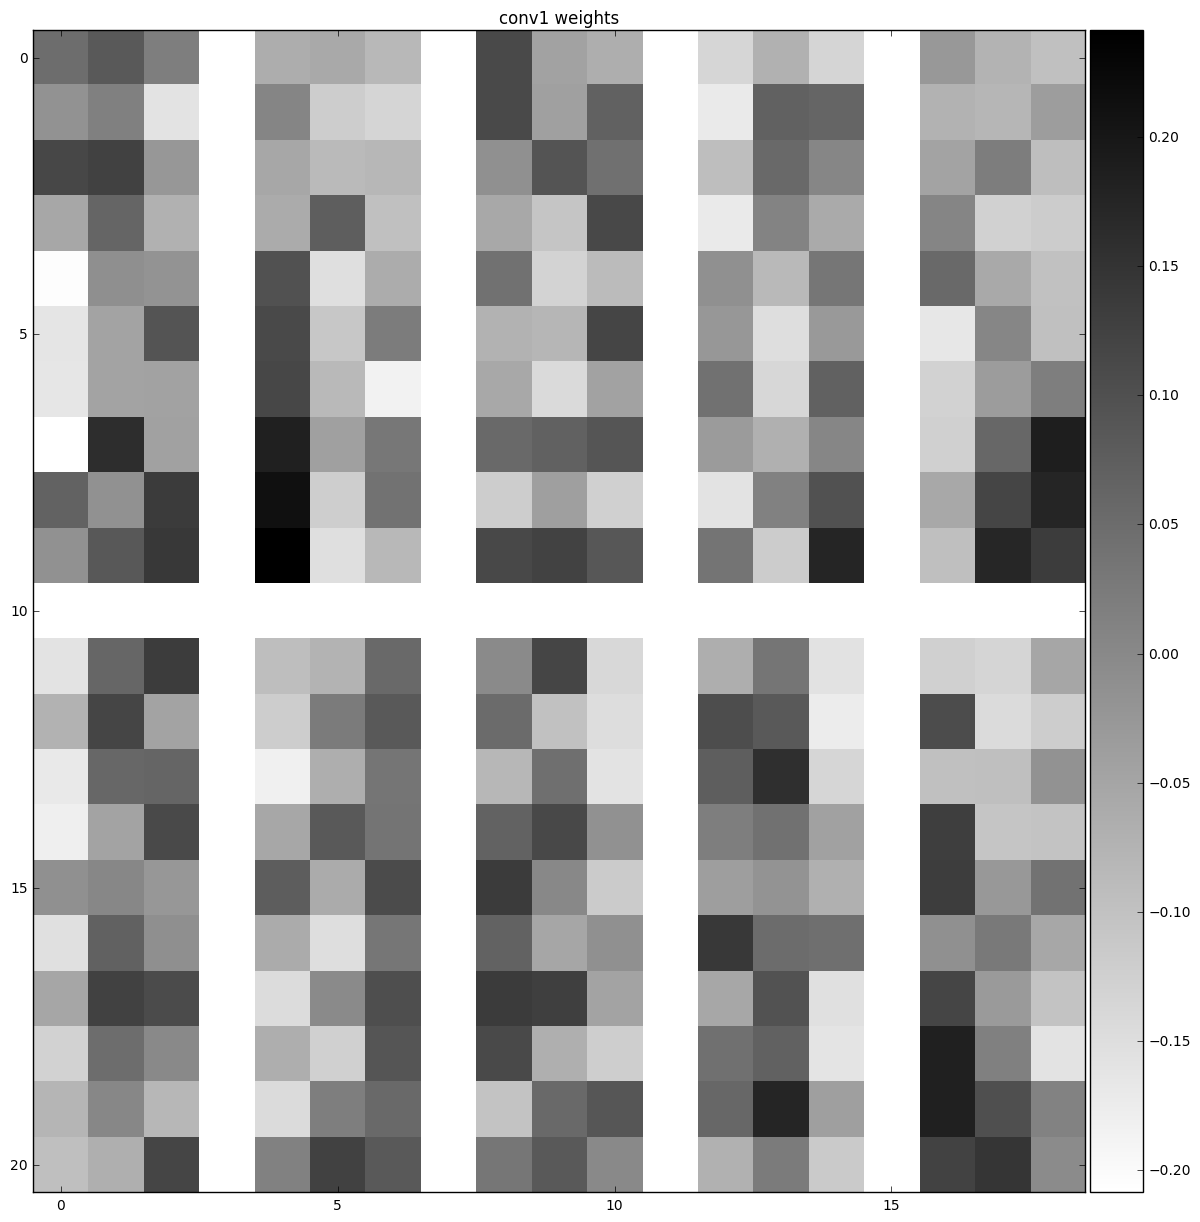

In [94]:
plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
nice_imshow(plt.gca(), make_mosaic(W_filters_transposed, 2, 5), cmap=cm.binary)

## CNN with 512 10x180 filters

In [7]:
W_filters_transposed = get_filters(model, 'conv2d_2')

(10, 180, 1, 512)
(512, 10, 180)


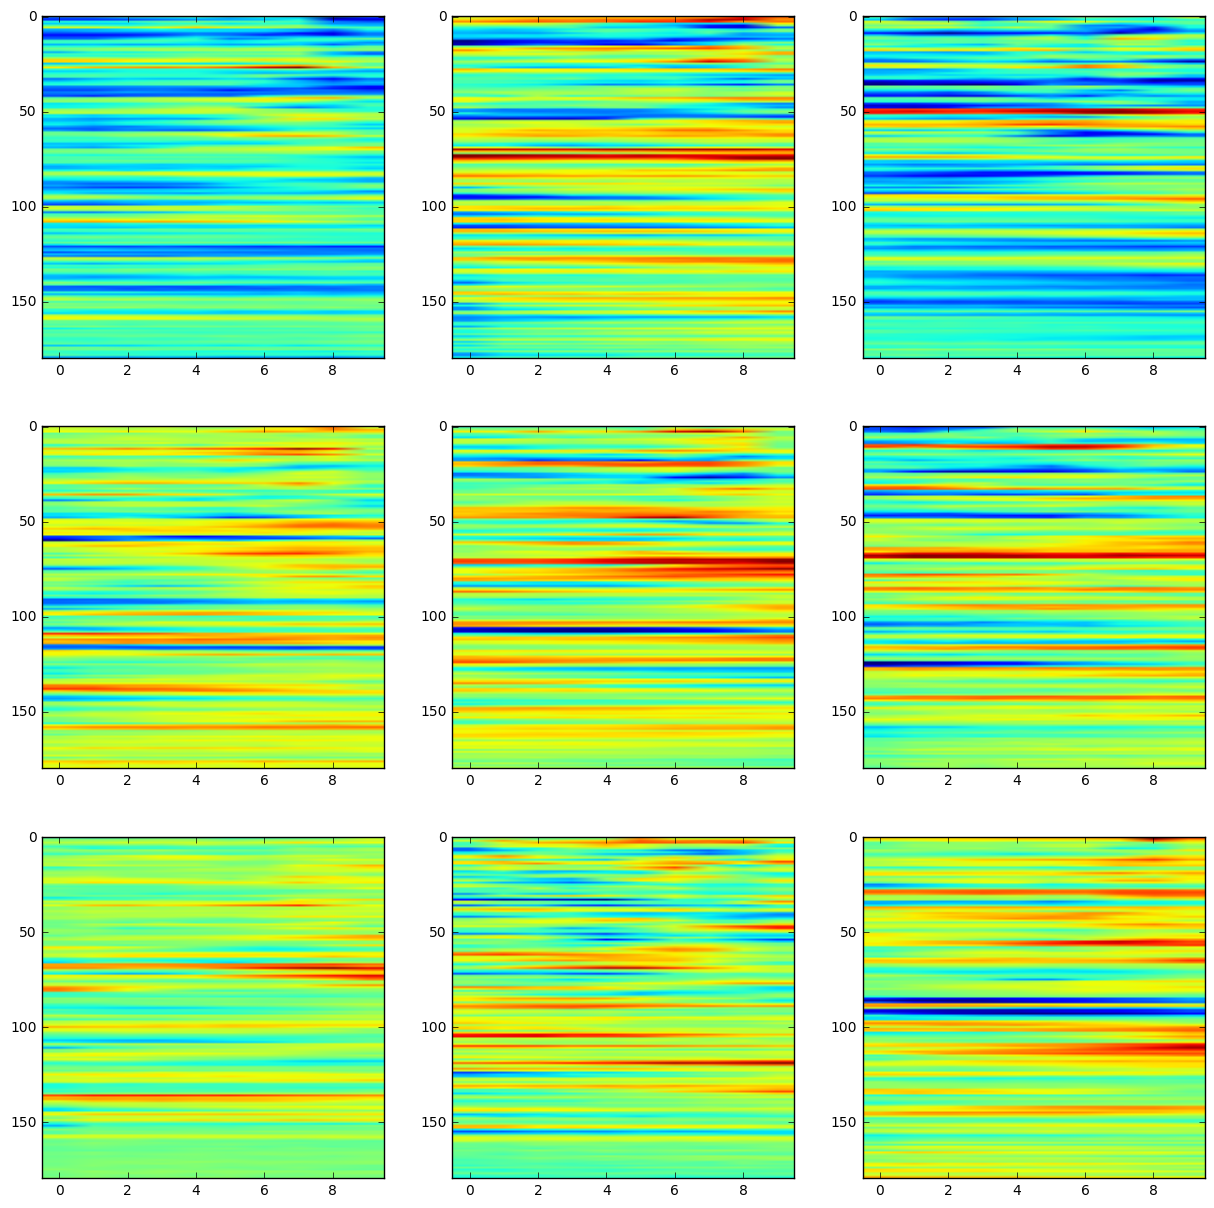

In [11]:
from random import randrange
n_rows = 3
n_cols = 3
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(15, 15))
_, n_frames, n_bins = W_filters_transposed.shape
aspect = n_bins / n_frames
for i in range(n_rows):
    for j in range(n_cols):
        _ = axarr[i, j].imshow(W_filters_transposed[randrange(W_filters_transposed.shape[0]), :, :].T, aspect=1/aspect)
        # _ = axarr[i, j].imshow(W_filters_transposed[i*n_cols + j, :, :].T, aspect=1/aspect)

In [10]:
fig.set_size_inches(n_cols*10, n_rows*10)
fig.savefig('test.png')